In [1]:
#pip install --upgrade pydata-google-auth google-cloud-bigquery[pandas]

In [1]:
import json
import pyspark as ps
import pandas as pd
import numpy as np
import datetime
from dateutil import relativedelta
from tqdm.notebook import trange, tqdm
from datetime import datetime
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

In [36]:
from google.cloud import bigquery
from google.oauth2 import service_account
#I set my global variable to my google credentials.


project_id = 'spheric-method-283202'

# TODO(developer): Set key_path to the path to the service account key
#                  file.
# key_path = "path/to/service_account.json"

credentials = service_account.Credentials.from_service_account_file(
    "/Users/Cliff/dev/google_key.json",
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

# Construct a reference to the "google_analytics_sample" dataset
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")



In [10]:
#Dates

sdate = datetime.date(2016,8,1)
edate = datetime.date(2017,8,1)

In [4]:
def clean_dates(sdate, edate):
    date_lst = []
    cleaned = []
    x = pd.date_range(sdate,edate,freq='d')
    for i in x:
        date_lst.append(pd.to_datetime(str(i)).strftime('%Y.%m.%d'))
    
    for date in date_lst:
        cleaned.append(date.replace('.',''))
    return cleaned
clean_dates = clean_dates(sdate,edate)


In [2]:
def filter_dict(dictionary, keys):
    #Takes dictionary and created new on based on keys wanted. 
    
    return {k: dictionary[k] for k in keys if k in dictionary}


def filter_dict_dict(embeded_dictionary):
    #Goes into filter_dict. Attempt to clean dictionary within dictionary.
    ecommerceaction = ['action_type']
    page = ['pagePath', 'pageTitle']
    product = ['productSKU', 'v2ProductName', 'v2ProductCategory', 'productVariant', 
           'productRevenue', 'productPrice', 'productQuantity']
    transactions = ['transactionId', 'transactionRevenue', 'transactionTax', 'transactionShipping']
    if embeded_dictionary == 'eCommerceAction':
        return {k: embeded_dictioanry[k] for k in emcommerceaction if k in embeded_dictionary}
    elif embeded_dictionary == 'page':
        return {k: embeded_dictioanry[k] for k in page if k in embeded_dictionary}
    elif embeded_dictionary == 'product':
        return {k: embeded_dictioanry[k] for k in product if k in embeded_dictionary}
    elif embeded_dictionary == 'transactions':
        return {k: embeded_dictioanry[k] for k in transactions if k in embeded_dictionary}
    else:
        pass

def literal_return(value):
    #Attempts to read each column string and convert to appropriate data type.
    try:
        return ast.literal_eval(value)
    except:
        return value
    
def filter_dict(dictionary, keys):
    #Takes dictionary and created new on based on keys wanted. 
    return {k: dictionary[k] for k in keys if k in dictionary}

def get_all_dataframes(date_list):
    df = pd.DataFrame()
    for i in tqdm(range(len(date_list))):
        # Construct a reference to the "ga_sessions_20170801" table
        table_ref = dataset_ref.table("ga_sessions_"+str(date_list[i]))

        # API request - fetch the table
        table = client.get_table(table_ref)
        
        #Columns Want
        columns = ['visitId', 'visitStartTime',
                  'date', 'totals', 'trafficSource', 'device',
                   'geoNetwork', 'channelGrouping'] #'hits'
        
        #First dataframe
        month_df = client.list_rows(table).to_dataframe()
        month_df = month_df[columns]
        
        #Turn columns into appropriate datatypes. 
        for column in columns:
            try:
                month_df[column] = month_df[column].apply(lambda x: literal_return(x))
            except:
                pass
        
        #Go into columns and remove useless data
        for column in columns:
            try:
                month_df[column] = month_df[column].apply(lambda x: {k:v for k,v in x.items() if v != 'not available in demo dataset'})
            except:
                pass
            
        #Keys I want to keep in each column dict.
        totals = ['hits', 'pageviews','timeOnSite','totalTransactionRevenue']
        trafficsource = ['referralPath', 'source','medium','adContent']
        hits = ['hitNumber', 'time','hour','minute','eCommerceAction', 
        'product', 'transactions']
        
        month_df['totals'] = month_df['totals'].apply(lambda x: filter_dict(x,totals))
        month_df['trafficSource'] = month_df['trafficSource'].apply(lambda x: filter_dict(x,trafficsource))
        #month_df['hits'] = month_df['hits'].apply(lambda y: list(map(lambda x: filter_dict(x,hits), y)))
        
        #Combine df
        df = pd.concat([df, month_df], axis = 0)
        df.reset_index(drop=True, inplace=True)
    
    df.to_json("test")
    
#get_all_dataframes(clean_dates)

In [3]:
def parse_dataframe(df):
    final_df = pd.DataFrame()
    for i in tqdm(range(0,len(df))):
        temp_row = df[i:i+1]
        final_df = final_df.append(parse_col(temp_row))
        final_df.reset_index(drop=True, inplace=True)
    return final_df
        
def parse_col(df):
    #Take downloaded data and parse out dictionaries into expanded dataframe.
    new_df = pd.DataFrame()  
    for col in df:
        if df[col].dtypes == 'O':
            temp = df[col].apply(pd.Series)
            new_df = pd.concat([new_df, temp], axis = 1)
        else:
            new_df = pd.concat([new_df, df[col]], axis = 1)

    return new_df
#df_clean = parse_dataframe(df)

Columns needed:
-visitId
-visitStartTime
-date

totals
    -hits
    -pageviews
    -timeOnSite
    -totaltransactionRevenue
   
trafficSource
    -referralPath
    -source
    -medium
    -keyword [I dont understand - remove]
    -adContent
device
    - [Get all]
geoNetwork
    - [Get all]
hits [Each is a list of dictionaries representing a page view]
    -hitNumber
    -time
    -hour
    -minute
    -eCommerceAction [Get only action_type]
    -page ['pagePath', 'pageTitle'] [Remove]
    -product [Get all remove later]
        -productSKU
        -v2ProductName
        -v2ProductCategory
        -productVariant
        -productRevenue
        -productPrice
        -productQuantity
    -transactions [Get all remove later]
        -transactionId
        -transactionRevenue
        -transactionTax
        -transactionShipping

channelGrouping
    

In [2]:
df = pd.read_csv('../ga_data.csv')

In [ ]:
df_parse = split_dates(df)

In [48]:
#Parse out dates in csv for easily plotting.
def split_dates(df):
    temp = df.copy()
    for i in tqdm(range(len(df))):
        temp_list = temp['Date'][i].split('-')
        temp['Month-Year'] = temp_list[1]+'-'+temp_list[0]
        temp['Day'] = temp_list[2]
    return df

#Takes dataframe, groups, finds groups below "other" threshold and combines them.
def create_other(df, columngroup, column, other):
    """
    INPUT:
    df = Dataframe
    columngroup = Column to groupby
    column = Column to sum
    other = threshold
    
    OUTPUT:
    Dataframe
    """
    #Group dataframe by columngroup and sum column.
    group = df.groupby([columngroup]).sum().sort_values(column)
    #Two dataframes one to stores values above and below "other" threshold.
    groups = pd.DataFrame()
    other_df = pd.DataFrame()
    for i in range(0,len(group)-1):
        if group.iloc[i:i+1][column][0]/sum(group[column]) < other:
            other_df = other_df.append(group.iloc[i:i+1])
        else:
            groups = groups.append(group.iloc[i:i+1])
    #Group groups into one row called other. 
    other_df['OTHER'] = 'OTHER'
    other_df = other_df.groupby('OTHER').sum()
    groups = groups.append(other_df)
    return groups


def pie_chart(df, columngroup, column, other, explode=None, title=None):
    #Groups dataframe, see create_other function
    group = create_other(df, columngroup, column, other)
    
    labels = group.index
    sizes = (group[column]/sum(group[column]))
    colors = plt.cm.tab20(range(20))
    
    explodes = None
    if explode !=None:
        explode_list = [0]*len(labels)
        explode_list[explode] = .075
        explodes = explode_list

    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.pie(sizes, explode=explodes, labels=labels, autopct='%1.1f%%', 
         pctdistance=.6, labeldistance=1.06, shadow=True, startangle=20
           ,colors = colors)
    ax.axis('equal')  
    
    mpl.rcParams['font.size'] = 14.0
    plt.title(f'{title}', color='w', bbox={'facecolor':'black', 'pad':7})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rc('font', weight='bold')
    plt.tight_layout()
    plt.show()

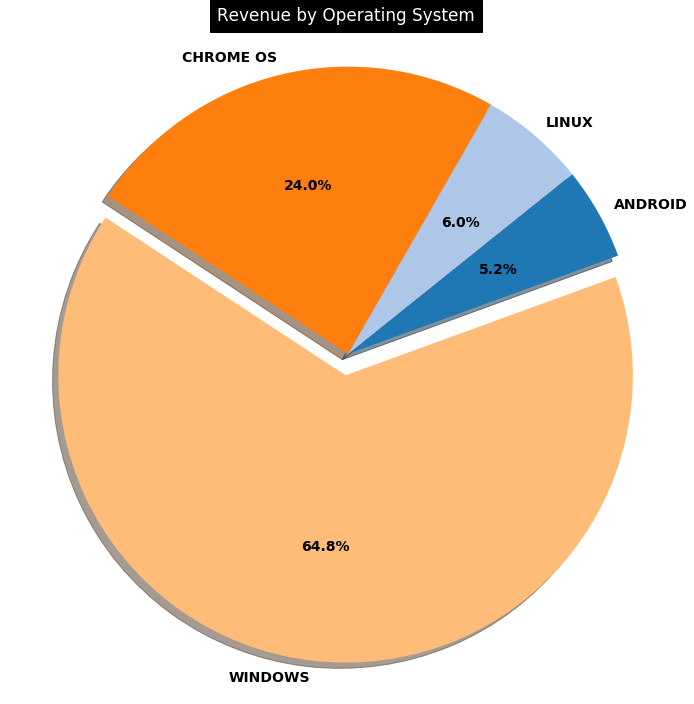

In [12]:
pie_chart(df, 'operatingsystem', 'totalrevenue', .02, 3, 'Revenue by Operating System')

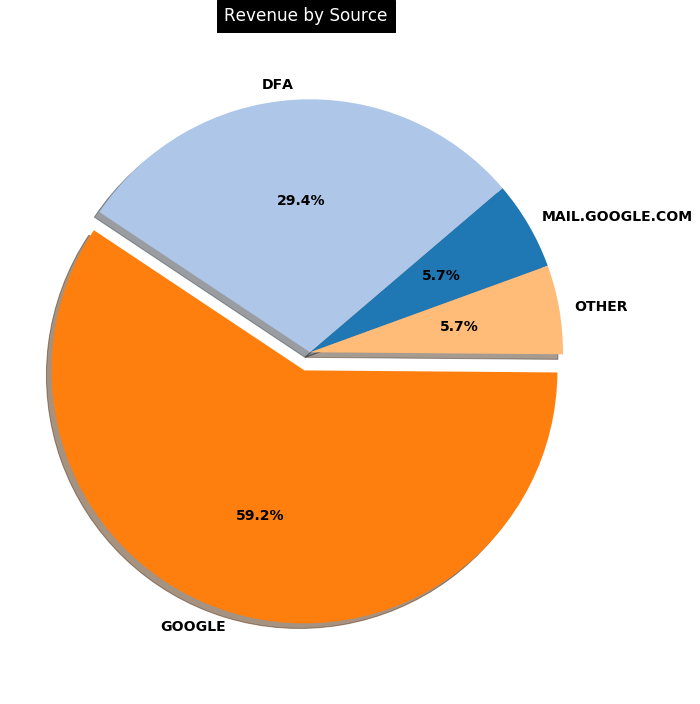

In [13]:
pie_chart(df, 'source', 'totalrevenue', .01, 2, 'Revenue by Source')

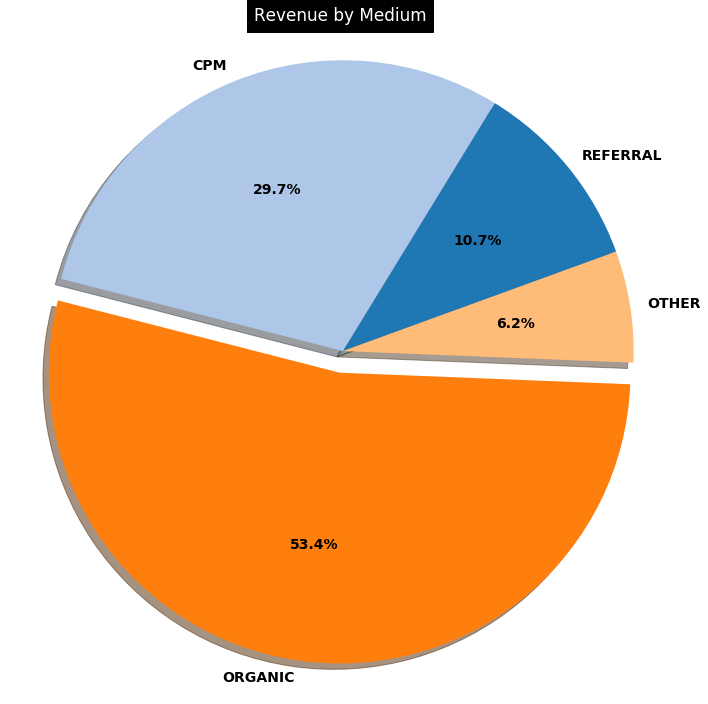

In [14]:
pie_chart(df, 'medium', 'totalrevenue', 0.02, 2, 'Revenue by Medium')

In [3]:
df.head()

,visit,date,yearmonth,day,pageviews,timeonsite,totalrevenue,source,medium,operatingsystem,devicecategory,country,region,city
0,1,2016-08-01,201608,1,3.0,54.0,NaN,YOUTUBE.COM,REFERRAL,WINDOWS,DESKTOP,United States,not available in demo dataset,not available in demo dataset
1,1,2016-08-01,201608,1,3.0,529.0,NaN,YOUTUBE.COM,REFERRAL,WINDOWS,DESKTOP,United States,California,San Jose
2,1,2016-08-01,201608,1,3.0,323.0,NaN,YOUTUBE.COM,REFERRAL,MACINTOSH,DESKTOP,Philippines,Metro Manila,Quezon City
3,1,2016-08-01,201608,1,4.0,135.0,NaN,YOUTUBE.COM,REFERRAL,WINDOWS,DESKTOP,Canada,not available in demo dataset,not available in demo dataset
4,1,2016-08-01,201608,1,2.0,122.0,NaN,YOUTUBE.COM,REFERRAL,WINDOWS,DESKTOP,United States,not available in demo dataset,not available in demo dataset


In [5]:
group = df.groupby(['yearmonth']).sum()
group

,visit,day,pageviews,timeonsite,totalrevenue
yearmonth,,,,,
201608,68228,1094130,332148.0,10180812.0,188529.87
201609,64551,1014941,297986.0,9271962.0,135225.04
201610,89611,1542827,306346.0,9737562.0,122340.70
201611,105104,1650030,321124.0,9380231.0,131268.96
201612,67916,898181,292613.0,9666461.0,162333.06
201701,54121,886188,220231.0,7490507.0,104227.76
201702,53279,772734,203009.0,7357604.0,114660.42
201703,60383,986753,227645.0,8496100.0,148912.35
201704,57402,887881,211156.0,8302061.0,220786.83


In [19]:
group = group[:-1]
group

,visit,day,pageviews,timeonsite,totalrevenue
yearmonth,,,,,
201608,68228,1094130,332148.0,10180812.0,188529.87
201609,64551,1014941,297986.0,9271962.0,135225.04
201610,89611,1542827,306346.0,9737562.0,122340.70
201611,105104,1650030,321124.0,9380231.0,131268.96
201612,67916,898181,292613.0,9666461.0,162333.06
201701,54121,886188,220231.0,7490507.0,104227.76
201702,53279,772734,203009.0,7357604.0,114660.42
201703,60383,986753,227645.0,8496100.0,148912.35
201704,57402,887881,211156.0,8302061.0,220786.83


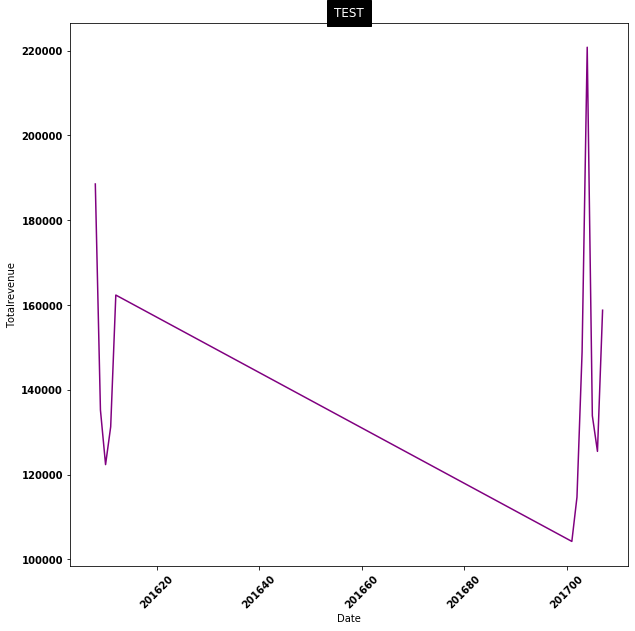

In [20]:
def time_series(df, column, title=None):
    #Groups dataframe, see create_other function
    group = df.groupby(['yearmonth']).sum()
    group = group[:-1]
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add x-axis and y-axis
    ax.plot(group.index.values,
            group[column],
            color='purple')

    # Set title and labels for axes
    ax.set(xlabel="Date",
           ylabel=column.title())

    # Rotate tick marks on x-axis
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.title(f'{title}', color='w', bbox={'facecolor':'black', 'pad':7})
    plt.show()
time_series(df, 'totalrevenue', 'TEST')